<a href="https://colab.research.google.com/github/brunoedcf/NLP_2022_1/blob/main/Word2Vec_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pythainlp
!pip install advertools
!pip install -U gensim

# ***Imports***

In [ ]:
import pandas as pd
import numpy as np
import re
import keras
import pythainlp
import advertools as adv
import matplotlib.pyplot as plt


from gensim.models import KeyedVectors
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Embedding, GlobalMaxPooling1D, Activation, Dropout

import nltk
nltk.download('punkt')

In [3]:
data_path = 'https://raw.githubusercontent.com/brunoedcf/bert-base-multilingual-cased_Language_Classifier/main/dataset.csv'

In [4]:
df = pd.read_csv(data_path)
df

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
...,...,...
21995,hors du terrain les années et sont des année...,French
21996,ใน พศ หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...,Thai
21997,con motivo de la celebración del septuagésimoq...,Spanish
21998,年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...,Chinese


In [5]:
text = df['Text'].tolist()
lang = df['language'].tolist()

# ***Pre-Processing***

In [6]:
def pre_process(text):
  treated = re.sub(r'[\/\。\・\、\，\「\」\、\-\（\）\『\』\；\：\：\－\”\·\–\~\—\«\—]', ' ', text)
  treated = re.sub(r'[\[\]\,\.\"\'\(\)\%\:\;\<\>\?\!\+\*\&\$\#\@\《\》\—]', ' ', treated)
  treated = re.sub(r'\\n', ' ', treated)
  treated = re.sub(r'[0-9]', ' ', treated)
  treated = re.sub(r'\\u200c', ' ', treated)
  treated = re.sub(r'\\u200b', ' ', treated)
  treated = re.sub(r'\s+', ' ', treated)
  treated = treated.lower()

  return treated

In [7]:
text = [pre_process(t) for t in text]

In [8]:
for i, row in enumerate(text):

  if lang[i] == 'Thai':
    for stopword in pythainlp.corpus.common.thai_stopwords():
      if stopword in row:
        text[i] = pre_process(re.sub(stopword, ' ', row).strip())

  elif lang[i] == 'Japanese':
    for stopword in adv.stopwords['japanese']:
      if stopword in row:
        text[i] = pre_process(re.sub(stopword, ' ', row).strip())

  elif lang[i] == "Chinese":
    for stopword in adv.stopwords['chinese']:
      if stopword in row:
        text[i] = pre_process(re.sub(stopword, ' ', row).strip())

# ***Split in Training, Test and Validation***

In [9]:
train_x, test_x, train_y, test_y = train_test_split(text, lang, test_size=0.33, random_state=42)
test_x, valid_x, test_y, valid_y = train_test_split(test_x, test_y, test_size=0.33, random_state=42)

# ***Labels to Categorical***

In [10]:
df_train_y = pd.Categorical(train_y)
df_train_y_int = df_train_y.codes
train_y = to_categorical(df_train_y_int)

df_test_y = pd.Categorical(test_y)
df_test_y_int = df_test_y.codes
test_y = to_categorical(df_test_y_int)

df_valid_y = pd.Categorical(valid_y)
df_valid_y_int = df_valid_y.codes
valid_y = to_categorical(df_valid_y_int)

# ***Count Vocabulary***

In [11]:
vocab = {}
for text in train_x:
  for word in text.split():
    if word not in vocab:
      vocab[word] = 1

In [12]:
vocab_size = len(vocab)
vocab_size

228705

# ***Tokenizer***

In [13]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_x)

In [14]:
word_index = tokenizer.word_index

In [15]:
vocab_size = len(word_index) + 1

In [16]:
train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)
valid_sequences = tokenizer.texts_to_sequences(valid_x)

In [17]:
max_length = 64
trunc_type = 'post'
padding_type = 'post'

In [18]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# ***Transformar os dados df_train_x, df_test_x e df_valid_x em um embedding do Word2Vec antes de treinar***

# ***Treinando o Embedding Word2Vec***

In [19]:
sentences = [sent.split() for sent in train_x]

In [ ]:
model_word2vec = Word2Vec(sentences, vector_size=100, min_count=1, window=6, sg=1,workers=4)

In [23]:
model_word2vec.wv.most_similar('parar')

[('bizantina', 0.9900647401809692),
 ('lácio', 0.9893724918365479),
 ('pai', 0.9886687994003296),
 ('padrões', 0.9886593818664551),
 ('bloco', 0.9884536862373352),
 ('beja', 0.9883956909179688),
 ('setúbal', 0.9882718324661255),
 ('escreveu', 0.9882026314735413),
 ('júnior', 0.9880039095878601),
 ('heráldicos', 0.9877657294273376)]

# ***Criando a Matriz de Embedding***

In [24]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in model_word2vec.wv:
      embedding_matrix[i] = model_word2vec.wv.get_vector(word)
    else:
      embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25), 100)

In [25]:
embedding_dim = len(model_word2vec.wv[0])
embedding_dim

100

# ***Criando a Camada de Embedding***

In [26]:
embedding_layer = Embedding(input_dim = vocab_size,
                            output_dim = embedding_dim,
                            weights = [embedding_matrix],
                            input_length=64,
                            trainable=False)

# ***Modelo***

In [27]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=6, strides=1))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(22, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 100)           22868400  
                                                                 
 conv1d (Conv1D)             (None, 59, 128)           76928     
                                                                 
 activation (Activation)     (None, 59, 128)           0         
                                                                 
 dropout (Dropout)           (None, 59, 128)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [28]:
sgd = SGD(learning_rate=0.02)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(train_padded, train_y,validation_data=(valid_padded, valid_y), epochs=50)

Epoch 1/50
461/461 [==============================] - 19s 39ms/step - loss: 1.1096 - accuracy: 0.7018 - val_loss: 0.5858 - val_accuracy: 0.8873
Epoch 2/50
461/461 [==============================] - 16s 35ms/step - loss: 0.4768 - accuracy: 0.8656 - val_loss: 0.3922 - val_accuracy: 0.9065
Epoch 3/50
461/461 [==============================] - 28s 61ms/step - loss: 0.3548 - accuracy: 0.8878 - val_loss: 0.3303 - val_accuracy: 0.9124
Epoch 4/50
461/461 [==============================] - 15s 33ms/step - loss: 0.3184 - accuracy: 0.8990 - val_loss: 0.3165 - val_accuracy: 0.9094
Epoch 5/50
461/461 [==============================] - 14s 30ms/step - loss: 0.2864 - accuracy: 0.9041 - val_loss: 0.2863 - val_accuracy: 0.9115
Epoch 6/50
461/461 [==============================] - 14s 30ms/step - loss: 0.2751 - accuracy: 0.9060 - val_loss: 0.2714 - val_accuracy: 0.9144
Epoch 7/50
461/461 [==============================] - 14s 30ms/step - loss: 0.2613 - accuracy: 0.9117 - val_loss: 0.2634 - val_accuracy:

In [29]:
target_names = pd.Categorical(lang).categories

y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(df_test_y_int,y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Arabic       0.99      1.00      1.00       240
     Chinese       0.49      0.37      0.42       221
       Dutch       1.00      0.99      0.99       209
     English       0.86      0.96      0.91       212
    Estonian       0.98      0.97      0.98       222
      French       0.97      0.98      0.97       217
       Hindi       1.00      0.97      0.99       239
  Indonesian       0.99      0.98      0.98       212
    Japanese       0.69      0.24      0.36       212
      Korean       1.00      0.99      0.99       219
       Latin       0.90      0.94      0.92       218
     Persian       1.00      1.00      1.00       212
   Portugese       0.97      0.98      0.98       211
      Pushto       1.00      0.97      0.98       216
    Romanian       1.00      0.98      0.99       232
     Russian       0.99      0.99      0.99       237
     Spanish       0.99      0.98      0.98       216
     Swedish       1.00    

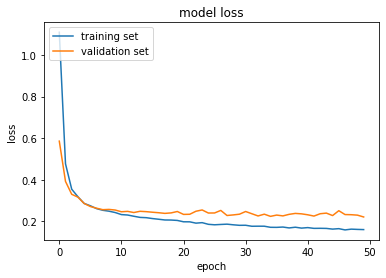

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()
plt.savefig('historyfine_Word2Vec_CNN.eps', format='eps')

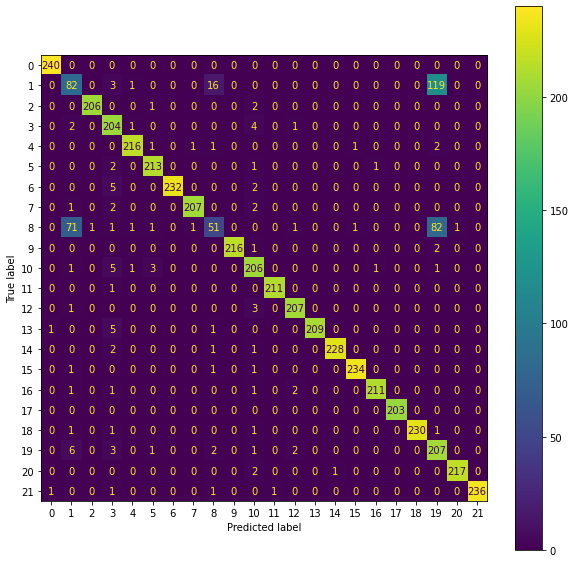

<Figure size 432x288 with 0 Axes>

In [31]:
disp = ConfusionMatrixDisplay.from_predictions(df_test_y_int, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(10) 
fig.set_figheight(10)
plt.show()
plt.savefig('confmatrix_Word2Vec_CNN.eps', format='eps')